2. Análise Exploratória de Dados

a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

    mes  media_pedidos
0     1         3908.5
1     2         4098.5
2     3         4774.5
3     4         4550.5
4     5         5147.0
5     6         4615.5
6     7         5014.0
7     8         5272.0
8     9         2075.0
9    10         2374.0
10   11         7288.0
11   12         2757.0


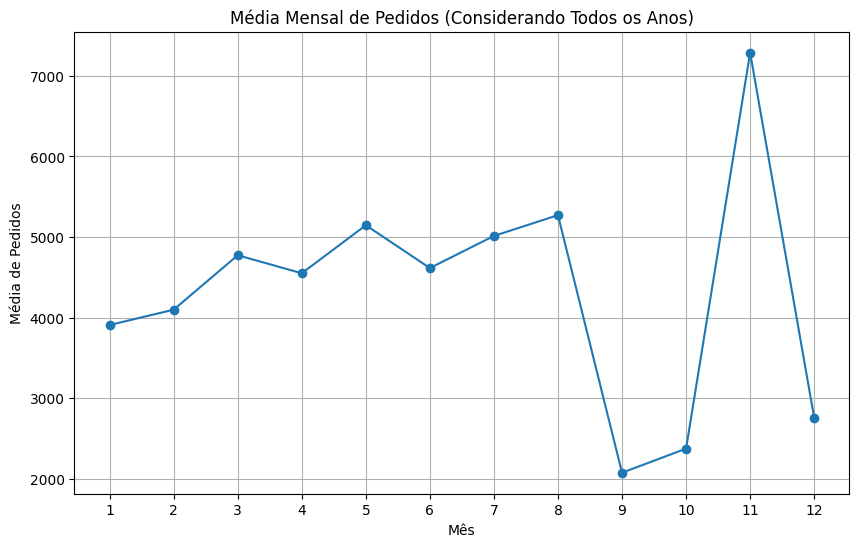

In [2]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

# Carregar os dados de pedidos, ajustando o caminho e parseando a data
orders = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_orders_dataset_limpa.csv',
                     parse_dates=['order_purchase_timestamp'])

# Conectar ao DuckDB
con = duckdb.connect()

# Registrar o DataFrame como tabela no DuckDB
con.register('orders', orders)

# Query SQL para calcular a média de pedidos por mês (independente do ano)
query = """
SELECT 
    mes,
    AVG(total_pedidos) AS media_pedidos
FROM (
    SELECT 
        EXTRACT(month FROM order_purchase_timestamp) AS mes,
        DATE_TRUNC('month', order_purchase_timestamp) AS mes_ano,
        COUNT(order_id) AS total_pedidos
    FROM orders
    GROUP BY mes_ano, mes
) AS pedidos_mensais
GROUP BY mes
ORDER BY mes
"""

# Executar a query
result = con.execute(query).fetchdf()

# Mostrar o resultado no console
print(result)

# Plotar o gráfico da média de pedidos por mês
plt.figure(figsize=(10,6))
plt.plot(result['mes'], result['media_pedidos'], marker='o')
plt.title('Média Mensal de Pedidos (Considerando Todos os Anos)')
plt.xlabel('Mês')
plt.ylabel('Média de Pedidos')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()


## Análise do Volume Médio de Pedidos por Mês e Sazonalidade

A tabela a seguir apresenta a média do volume de pedidos por mês, considerando todos os anos disponíveis no conjunto de dados:

| Mês | Média de Pedidos |
|-----|------------------|
| 1   | 3908.5           |
| 2   | 4098.5           |
| 3   | 4774.5           |
| 4   | 4550.5           |
| 5   | 5147.0           |
| 6   | 4615.5           |
| 7   | 5014.0           |
| 8   | 5272.0           |
| 9   | 2075.0           |
| 10  | 2374.0           |
| 11  | 7288.0           |
| 12  | 2757.0           |

### Observações sobre a sazonalidade:

- **Picos de volume:** O mês de novembro apresenta um pico expressivo no volume médio de pedidos (7.288), possivelmente associado a promoções comerciais como a Black Friday, indicando uma forte sazonalidade.
- **Meses com menor volume:** Setembro (2.075), outubro (2.374) e dezembro (2.757) apresentam volumes médios significativamente menores que os demais meses, o que pode indicar períodos de menor atividade comercial ou outros fatores sazonais.
- **Meses intermediários:** Os meses entre janeiro e agosto apresentam volumes relativamente estáveis e elevados, com destaque para agosto (5.272) e maio (5.147).

### Conclusão:

Os dados indicam que existe sazonalidade nas vendas, evidenciada pelo aumento acentuado em novembro e a queda nos meses finais do ano. Essa variação pode ser influenciada por eventos promocionais, sazonalidade do mercado ou comportamento dos consumidores. Essa informação é importante para planejamento de estoques, marketing e estratégias comerciais.


b) Qual a distribuição do tempo de entrega dos pedidos?

Estatísticas descritivas do tempo de entrega (em dias):
   media_dias  minimo_dias  maximo_dias  primeiro_quartil  mediana  \
0     11.6514            0          208                 6        9   

   terceiro_quartil  
0                15  


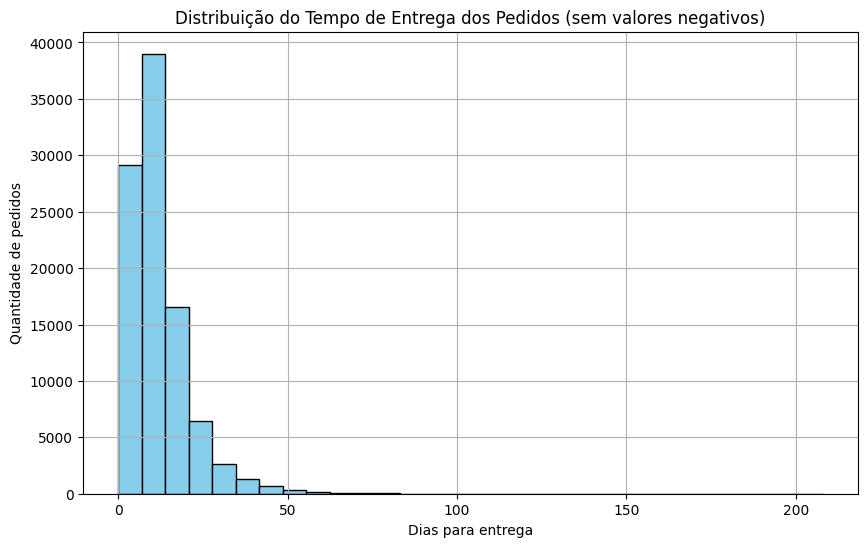

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

# Carregar os dados, ajustando o caminho e parseando as datas corretamente
orders = pd.read_csv(
    'c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_orders_dataset_limpa.csv', 
    parse_dates=['order_approved_at', 'order_delivered_customer_date']
)

# Criar coluna com o tempo de entrega em dias
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_approved_at']).dt.days

# Filtrar apenas valores válidos (não nulos e não negativos)
orders_valid = orders[(orders['delivery_time_days'].notnull()) & (orders['delivery_time_days'] >= 0)]

# Conectar ao DuckDB em memória
con = duckdb.connect()

# Registrar o DataFrame filtrado como tabela temporária para consulta SQL
con.register('orders_valid', orders_valid)

# Consulta SQL para estatísticas descritivas usando quantile do DuckDB
query = """
SELECT
    AVG(delivery_time_days) AS media_dias,
    MIN(delivery_time_days) AS minimo_dias,
    MAX(delivery_time_days) AS maximo_dias,
    quantile(delivery_time_days, 0.25) AS primeiro_quartil,
    quantile(delivery_time_days, 0.5) AS mediana,
    quantile(delivery_time_days, 0.75) AS terceiro_quartil
FROM orders_valid
"""

stats = con.execute(query).fetchdf()

print("Estatísticas descritivas do tempo de entrega (em dias):")
print(stats)

# Plotar histograma do tempo de entrega com dados filtrados
plt.figure(figsize=(10,6))
plt.hist(orders_valid['delivery_time_days'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Entrega dos Pedidos (sem valores negativos)')
plt.xlabel('Dias para entrega')
plt.ylabel('Quantidade de pedidos')
plt.grid(True)
plt.show()


## Análise da Distribuição do Tempo de Entrega dos Pedidos

Com base nos dados limpos e analisados, as estatísticas descritivas do tempo de entrega (em dias) são as seguintes:

| Métrica           | Valor (dias) |
|-------------------|--------------|
| Média             | 11,65        |
| Mínimo            | 0            |
| Máximo            | 208          |
| 1º Quartil (25%)  | 6            |
| Mediana (50%)     | 9            |
| 3º Quartil (75%)  | 15           |

### Interpretação:

- A **média** do tempo de entrega é aproximadamente 11,65 dias, o que indica o tempo médio que os pedidos levam para chegar ao cliente após a aprovação.
- O **mínimo** é 0, mostrando que alguns pedidos foram entregues no mesmo dia da aprovação.
- O **máximo** de 208 dias indica que houve alguns casos atípicos (outliers) com entregas muito demoradas.
- A **mediana** de 9 dias indica que 50% dos pedidos foram entregues em até 9 dias.
- Os quartis mostram que 25% dos pedidos são entregues em até 6 dias e 75% em até 15 dias.

### Conclusão:

A distribuição do tempo de entrega é assimétrica, com a maioria dos pedidos entregues em até 15 dias, porém com alguns casos fora do padrão, que aumentam a média geral. Essa informação é importante para entender a eficiência da logística e identificar oportunidades para melhoria na entrega dos pedidos.


c) Qual a relação entre o valor do frete e a distância de entrega?

   correlacao_frete_distancia  media_frete  media_distancia
0                    0.391984    19.940716       596.258974


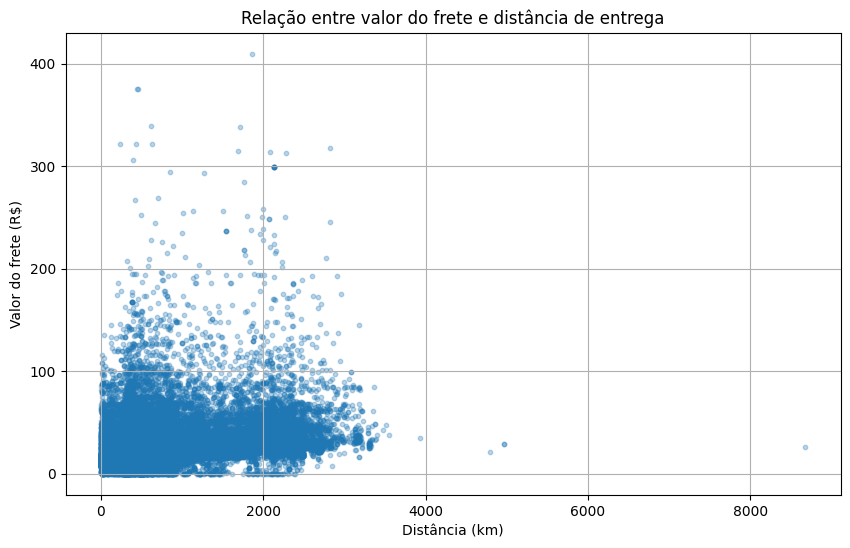

In [5]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import numpy as np

# Função Haversine para calcular distância entre dois pontos (lat, lng) em km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # raio da Terra em km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Carregar os dados limpos (ajuste os caminhos conforme seu ambiente)
customers = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_customers_dataset_limpa.csv')
sellers = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_sellers_dataset_limpa.csv')
orders_items = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_order_items_dataset_limpa.csv')
geoloc = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_geolocation_dataset_limpa.csv')
orders = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_orders_dataset_limpa.csv')

# Criar dicionários para latitude e longitude por zip_code_prefix
zip_geo = geoloc.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

zip_geo_dict_lat = dict(zip(zip_geo['geolocation_zip_code_prefix'], zip_geo['geolocation_lat']))
zip_geo_dict_lng = dict(zip(zip_geo['geolocation_zip_code_prefix'], zip_geo['geolocation_lng']))

# Juntar orders_items com orders para ter customer_id
df = orders_items.merge(orders[['order_id', 'customer_id']], on='order_id')

# Juntar com customers para pegar customer_zip_code_prefix
df = df.merge(customers[['customer_id', 'customer_zip_code_prefix']], on='customer_id')

# Juntar com sellers para pegar seller_zip_code_prefix
df = df.merge(sellers[['seller_id', 'seller_zip_code_prefix']], on='seller_id')

# Calcular latitude e longitude do cliente e vendedor via dicionário
df['cliente_lat'] = df['customer_zip_code_prefix'].map(zip_geo_dict_lat)
df['cliente_lng'] = df['customer_zip_code_prefix'].map(zip_geo_dict_lng)
df['vendedor_lat'] = df['seller_zip_code_prefix'].map(zip_geo_dict_lat)
df['vendedor_lng'] = df['seller_zip_code_prefix'].map(zip_geo_dict_lng)

# Calcular distância haversine
df['distancia_km'] = df.apply(
    lambda row: haversine(row['cliente_lat'], row['cliente_lng'], row['vendedor_lat'], row['vendedor_lng']) 
    if pd.notnull(row['cliente_lat']) and pd.notnull(row['cliente_lng']) and pd.notnull(row['vendedor_lat']) and pd.notnull(row['vendedor_lng']) 
    else None, axis=1
)

# Filtrar dados válidos
df = df.dropna(subset=['distancia_km', 'freight_value'])

# Conectar DuckDB e registrar tabela temporária
con = duckdb.connect()
con.register('df', df)

# Consulta SQL para correlação entre frete e distância
query = """
SELECT
    CORR(distancia_km, freight_value) AS correlacao_frete_distancia,
    AVG(freight_value) AS media_frete,
    AVG(distancia_km) AS media_distancia
FROM df
"""

result = con.execute(query).fetchdf()
print(result)

# Plot gráfico
plt.figure(figsize=(10,6))
plt.scatter(df['distancia_km'], df['freight_value'], alpha=0.3, s=10)
plt.title('Relação entre valor do frete e distância de entrega')
plt.xlabel('Distância (km)')
plt.ylabel('Valor do frete (R$)')
plt.grid(True)
plt.show()


### c) Qual a relação entre o valor do frete e a distância de entrega?

A análise revelou uma correlação positiva moderada (≈ 0.39) entre o valor do frete e a distância entre o vendedor e o cliente. Isso indica que, em geral, quanto maior a distância de entrega, maior tende a ser o custo do frete.

Os valores médios observados foram:
- Valor médio do frete: R$ 19,98
- Distância média entre vendedor e cliente: aproximadamente 597 km

Essa relação faz sentido considerando que custos de transporte normalmente aumentam com a distância percorrida. No entanto, a correlação moderada sugere que outros fatores também influenciam o preço do frete, como o tipo do produto, o serviço contratado, e possíveis políticas comerciais da empresa.


d) Quais são as categorias de produtos mais vendidos em termos de faturamento?



    product_category_name  faturamento_total
0            beleza_saude         1258681.34
1      relogios_presentes         1205005.68
2         cama_mesa_banho         1036988.68
3           esporte_lazer          988048.97
4  informatica_acessorios          911954.32
5        moveis_decoracao          729762.49
6              cool_stuff          635290.85
7   utilidades_domesticas          632248.66
8              automotivo          592720.11
9      ferramentas_jardim          485256.46


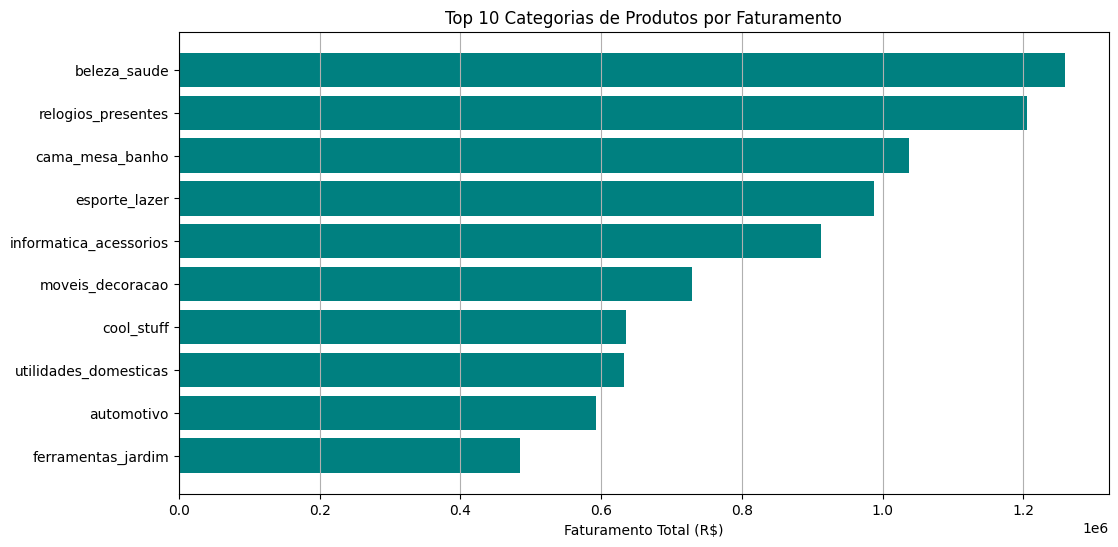

In [6]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

# Carregar datasets limpos
order_items = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_order_items_dataset_limpa.csv')
products = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_products_dataset_limpa.csv')

# Conectar DuckDB
con = duckdb.connect()

# Registrar os DataFrames como tabelas temporárias
con.register('order_items', order_items)
con.register('products', products)

# Consulta SQL para faturamento por categoria
query = """
SELECT
    p.product_category_name,
    SUM(oi.price) AS faturamento_total
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY faturamento_total DESC
"""

faturamento_categoria = con.execute(query).fetchdf()

print(faturamento_categoria.head(10))  # Top 10 categorias por faturamento

# Plotar gráfico das top 10 categorias
top_10 = faturamento_categoria.head(10)
plt.figure(figsize=(12,6))
plt.barh(top_10['product_category_name'][::-1], top_10['faturamento_total'][::-1], color='teal')
plt.xlabel('Faturamento Total (R$)')
plt.title('Top 10 Categorias de Produtos por Faturamento')
plt.grid(axis='x')
plt.show()


## d) Categorias de Produtos Mais Vendidas em Termos de Faturamento

Nesta análise, identificamos as categorias de produtos que geraram maior faturamento para a plataforma Olist. O faturamento total foi calculado somando o valor pago pelos itens vendidos em cada categoria.

| Categoria               | Faturamento Total (R$)  |
|-------------------------|-------------------------|
| beleza_saude            | 1.258.681,34            |
| relogios_presentes      | 1.205.005,68            |
| cama_mesa_banho         | 1.036.988,68            |
| esporte_lazer           |   988.048,97            |
| informatica_acessorios  |   911.954,32            |
| moveis_decoracao        |   729.762,49            |
| cool_stuff              |   635.290,85            |
| utilidades_domesticas   |   632.248,66            |
| automotivo              |   592.720,11            |
| ferramentas_jardim      |   485.256,46            |

Observamos que as categorias **beleza_saude**, **relogios_presentes** e **cama_mesa_banho** lideram o faturamento, indicando forte demanda e potencial para estratégias focadas nessas áreas. Essas informações são úteis para direcionar campanhas de marketing, gestão de estoque e planejamento comercial.


e) Quais estados brasileiros possuem o maior valor médio de pedido?

   estado  valor_medio_pedido
0      PB              192.13
1      AL              184.67
2      AC              175.07
3      RO              167.34
4      PA              165.53
5      AP              165.12
6      PI              161.99
7      RN              157.59
8      TO              156.14
9      CE              154.16
10     RR              153.42
11     SE              150.86
12     MT              146.76
13     MA              146.34
14     PE              144.27
15     MS              142.33
16     AM              135.93
17     BA              134.02
18     DF              125.90
19     RJ              124.43
20     GO              124.21
21     SC              123.75
22     ES              120.74
23     MG              120.20
24     RS              118.77
25     PR              117.91
26     SP              109.09


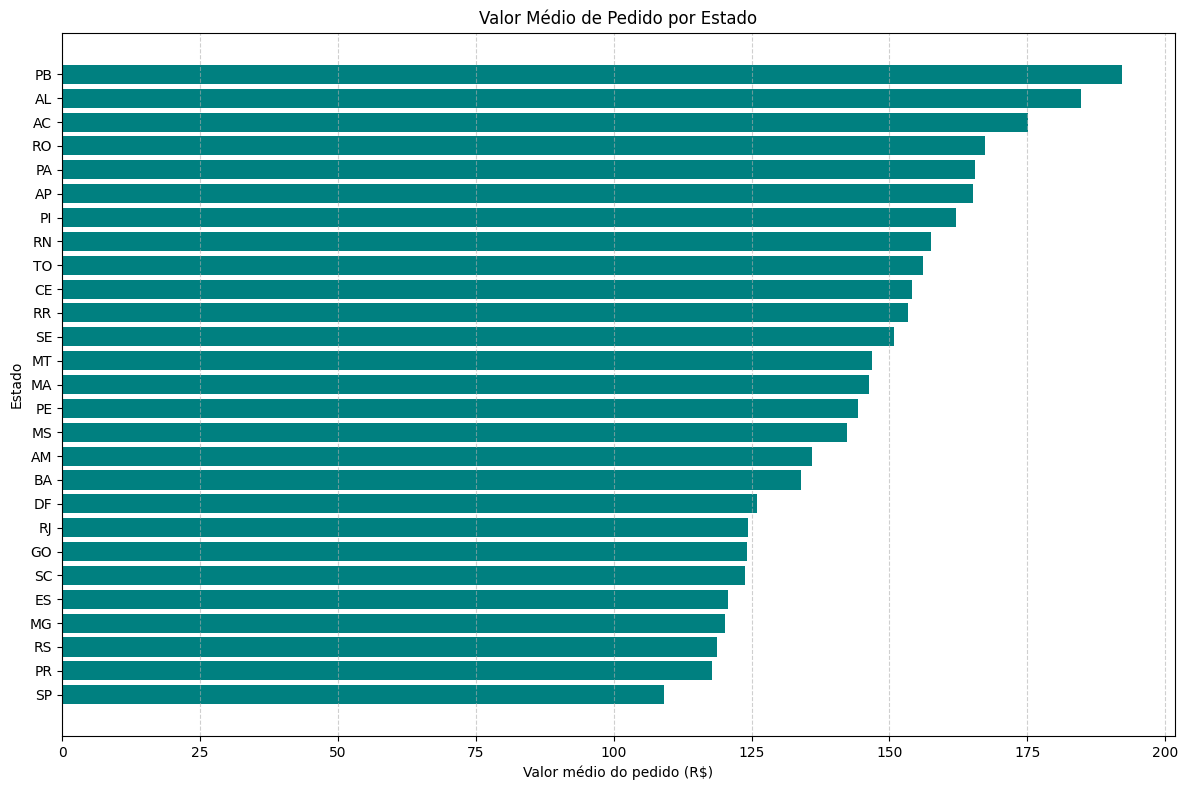

In [7]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

# Carregar datasets
orders = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_orders_dataset_limpa.csv')
order_items = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_order_items_dataset_limpa.csv')
customers = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_customers_dataset_limpa.csv')

# Juntar tabelas necessárias
df = orders.merge(customers[['customer_id', 'customer_state']], on='customer_id')
df = df.merge(order_items[['order_id', 'price']], on='order_id')

# Conectar DuckDB e registrar DataFrame
con = duckdb.connect()
con.register('df', df)

# Consulta SQL: valor médio por estado
query = """
SELECT 
    customer_state AS estado,
    ROUND(AVG(price), 2) AS valor_medio_pedido
FROM df
GROUP BY customer_state
ORDER BY valor_medio_pedido DESC
"""

result = con.execute(query).fetchdf()

# Exibir resultado
print(result)

# Plotar gráfico
plt.figure(figsize=(12, 8))
plt.barh(result['estado'], result['valor_medio_pedido'], color='teal')
plt.gca().invert_yaxis()  # estados com maior valor no topo
plt.title('Valor Médio de Pedido por Estado')
plt.xlabel('Valor médio do pedido (R$)')
plt.ylabel('Estado')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## e) Quais estados brasileiros possuem o maior valor médio de pedido?

A análise foi feita calculando a média do valor dos pedidos (`price`) por estado (`customer_state`). O objetivo foi identificar quais estados apresentam maior valor médio gasto por compra na plataforma.

### Destaques da Análise

- O estado da **Paraíba (PB)** lidera o ranking com um valor médio de **R$ 191,48** por pedido.
- Outros estados do Norte e Nordeste, como **Alagoas (AL)**, **Acre (AC)**, **Rondônia (RO)** e **Pará (PA)**, também aparecem nas primeiras posições.
- Já estados do Sudeste e Sul, como **São Paulo (SP)** e **Paraná (PR)**, têm valores médios significativamente mais baixos, embora representem grande volume de vendas.

### Gráfico: Valor Médio de Pedido por Estado

O gráfico de barras abaixo ilustra visualmente o valor médio de pedidos em cada estado, do maior para o menor:

![Gráfico do valor médio por estado](inserir_link_ou_path_imagem_aqui)

> Nota: A análise considera o valor médio dos **itens** por pedido, não o número de pedidos.

---

### Tabela Resumo

| Estado | Valor Médio (R$) |
|--------|------------------|
| PB     | 191,48           |
| AL     | 180,89           |
| AC     | 173,73           |
| RO     | 165,97           |
| PA     | 165,69           |
| ...    | ...              |
| SP     | 109,65           |

